In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import pandas as pd 
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')

print("Train data")
print(train.head())
print(train.info())

print('\nTest data')
print(test.head())
print(test.info())

print('\nHolidays data')
print(holidays.head())
print(holidays.info())

print('\nStore data')
print(stores.head())
print(stores.info())

print('\nTransactions data')
print(transactions.head())
print(transactions.info())

print('\nOil data')
print(oil.head())
print(oil.info())

Train data
        id  sales
0  3000888    0.0
1  3000889    0.0
2  3000890    0.0
3  3000891    0.0
4  3000892    0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28512 non-null  int64  
 1   sales   28512 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 445.6 KB
None

Test data
        id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id      

In [3]:
train.columns

Index(['id', 'sales'], dtype='object')

In [4]:
train.isna().sum()

id       0
sales    0
dtype: int64

In [5]:
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [6]:
oil['date'] = pd.to_datetime(oil['date']) 
oil = oil.sort_values(by='date') 
# Forward fill as an alternative to interpolation
oil['dcoilwtico'] = oil['dcoilwtico'].ffill()
oil['dcoilwtico'] = oil['dcoilwtico'].bfill()
oil.isna().sum()

date          0
dcoilwtico    0
dtype: int64

In [7]:
holidays.columns

Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

In [8]:
holidays['date'] = pd.to_datetime(holidays['date'])
holidays = holidays.sort_values(by='date')



In [9]:
transactions.columns

Index(['date', 'store_nbr', 'transactions'], dtype='object')

In [10]:
transactions['date'] = pd.to_datetime(transactions['date'])
transactions = transactions.sort_values(by='date')

In [11]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28512 non-null  int64  
 1   sales   28512 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 445.6 KB


,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


adding a date column in the train dataset

In [12]:
print(train['id'].min(),train['id'].max())
print(train['id'].diff().unique())

3000888 3029399
[nan  1.]


In [13]:
start_date = transactions['date'].min()
train['date'] = pd.date_range(start=start_date,periods=len(train),freq='D')

In [14]:
train = train.merge(holidays[['date','type','locale','locale_name','description','transferred']],
                   on='date',
                   how='left')

In [15]:
train['store_nbr'] = 1
train = train.merge(transactions[['date','store_nbr','transactions']],on=['date','store_nbr'],how='left')

 **Feature Engineering**

Creating date based features

In [16]:
train['day_of_week'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['quarter'] = train['date'].dt.quarter
train['year'] = train['date'].dt.year
train['is_weekend'] = train['date'].dt.dayofweek >=5
train.head()

,id,sales,date,type,locale,locale_name,description,transferred,store_nbr,transactions,day_of_week,month,quarter,year,is_weekend
0,3000888,0.0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False,1,NaN,1,1,1,2013,False
1,3000889,0.0,2013-01-02,NaN,NaN,NaN,NaN,NaN,1,2111.0,2,1,1,2013,False
2,3000890,0.0,2013-01-03,NaN,NaN,NaN,NaN,NaN,1,1833.0,3,1,1,2013,False
3,3000891,0.0,2013-01-04,NaN,NaN,NaN,NaN,NaN,1,1863.0,4,1,1,2013,False
4,3000892,0.0,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False,1,1509.0,5,1,1,2013,True


In [17]:
train.isna().sum()

id                  0
sales               0
date                0
type            28235
locale          28235
locale_name     28235
description     28235
transferred     28235
store_nbr           0
transactions    26838
day_of_week         0
month               0
quarter             0
year                0
is_weekend          0
dtype: int64

In [18]:
train['locale']=train['locale'].ffill()
train['locale_name'] = train['locale_name'].ffill()
train['description'] = train['description'].ffill()



In [19]:
train.isna().sum()

id                  0
sales               0
date                0
type            28235
locale              0
locale_name         0
description         0
transferred     28235
store_nbr           0
transactions    26838
day_of_week         0
month               0
quarter             0
year                0
is_weekend          0
dtype: int64

In [20]:
train['transactions'].ffill()

0           NaN
1        2111.0
2        1833.0
3        1863.0
4        1509.0
          ...  
28539    1693.0
28540    1693.0
28541    1693.0
28542    1693.0
28543    1693.0
Name: transactions, Length: 28544, dtype: float64

In [21]:
train.isna().sum()

id                  0
sales               0
date                0
type            28235
locale              0
locale_name         0
description         0
transferred     28235
store_nbr           0
transactions    26838
day_of_week         0
month               0
quarter             0
year                0
is_weekend          0
dtype: int64

In [22]:
train['transferred'].dtype

dtype('O')

In [23]:
train['type'] = train['type'].fillna('No Holiday')

In [24]:
train['transactions'] = train['transactions'].fillna(0)

In [25]:
train.isna().sum()

id                  0
sales               0
date                0
type                0
locale              0
locale_name         0
description         0
transferred     28235
store_nbr           0
transactions        0
day_of_week         0
month               0
quarter             0
year                0
is_weekend          0
dtype: int64

In [26]:
train.describe()

,id,sales,date,store_nbr,transactions,day_of_week,month,quarter,year
count,2.854400e+04,28544.0,28544,28544.0,28544.000000,28544.000000,28544.000000,28544.000000,28544.000000
mean,3.015129e+06,0.0,2051-12-28 15:51:57.713004544,1.0,90.987598,3.000666,6.519514,2.507567,2051.491487
min,3.000888e+06,0.0,2013-01-01 00:00:00,1.0,0.000000,0.000000,1.000000,1.000000,2013.000000
25%,3.007992e+06,0.0,2032-06-13 18:00:00,1.0,0.000000,1.000000,4.000000,2.000000,2032.000000
50%,3.015128e+06,0.0,2051-12-27 12:00:00,1.0,0.000000,3.000000,7.000000,3.000000,2051.000000
75%,3.022263e+06,0.0,2071-07-11 06:00:00,1.0,0.000000,5.000000,10.000000,4.000000,2071.000000
max,3.029399e+06,0.0,2091-01-23 00:00:00,1.0,3023.000000,6.000000,12.000000,4.000000,2091.000000
std,8.238168e+03,0.0,NaN,0.0,381.558198,2.000026,3.450295,1.117213,22.553822


The date looks so unrealistic.
checking if id is aligned with date

In [27]:
unique_dates = train[['id','date']].drop_duplicates()
print(f"Unique IDs: {unique_dates['id'].nunique()},Unique Dates: {unique_dates['date'].nunique()}")

Unique IDs: 28512,Unique Dates: 28512


In [28]:
print(f"Date range: {train['date'].min()} to {train['date'].max()}")

Date range: 2013-01-01 00:00:00 to 2091-01-23 00:00:00


In [29]:
start_date = '2012-01-01'
end_date = '2024-01-01'

train = train[(train['date'] >= start_date) & (train['date'] <= end_date)]

In [30]:
train.describe()

,id,sales,date,store_nbr,transactions,day_of_week,month,quarter,year
count,4.050000e+03,4050.0,4050,4050.0,4050.000000,4050.000000,4050.000000,4050.000000,4050.000000
mean,3.002889e+06,0.0,2018-06-24 16:23:49.333333504,1.0,641.271605,3.005185,6.529136,2.509877,2017.979506
min,3.000888e+06,0.0,2013-01-01 00:00:00,1.0,0.000000,0.000000,1.000000,1.000000,2013.000000
25%,3.001886e+06,0.0,2015-09-26 06:00:00,1.0,0.000000,1.000000,4.000000,2.000000,2015.000000
50%,3.002880e+06,0.0,2018-06-16 12:00:00,1.0,0.000000,3.000000,7.000000,3.000000,2018.000000
75%,3.003893e+06,0.0,2021-03-24 18:00:00,1.0,1702.500000,5.000000,10.000000,4.000000,2021.000000
max,3.004905e+06,0.0,2024-01-01 00:00:00,1.0,3023.000000,6.000000,12.000000,4.000000,2024.000000
std,1.159615e+03,0.0,NaN,0.0,820.566381,2.000178,3.445195,1.115475,3.162641


setting date as the index for easier time-based analysis

In [31]:
train.set_index('date',inplace= True)
train.sort_index(inplace=True)

In [32]:
train['sales'].isna().sum()

0

Feature Engineering

In [33]:
train['sales_7d_avg'] = train['sales'].rolling(window=7,min_periods=1).mean()

In [34]:
train.isna().sum()

id                 0
sales              0
type               0
locale             0
locale_name        0
description        0
transferred     3741
store_nbr          0
transactions       0
day_of_week        0
month              0
quarter            0
year               0
is_weekend         0
sales_7d_avg       0
dtype: int64

In [35]:
train['transferred'].dtype

dtype('O')

In [36]:
train['transferred'] = train['transferred'].astype(bool)

In [37]:
train['transferred'] = train['transferred'].fillna(False)

In [38]:
train.isna().sum()

id              0
sales           0
type            0
locale          0
locale_name     0
description     0
transferred     0
store_nbr       0
transactions    0
day_of_week     0
month           0
quarter         0
year            0
is_weekend      0
sales_7d_avg    0
dtype: int64

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4050 entries, 2013-01-01 to 2024-01-01
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            4050 non-null   int64  
 1   sales         4050 non-null   float64
 2   type          4050 non-null   object 
 3   locale        4050 non-null   object 
 4   locale_name   4050 non-null   object 
 5   description   4050 non-null   object 
 6   transferred   4050 non-null   bool   
 7   store_nbr     4050 non-null   int64  
 8   transactions  4050 non-null   float64
 9   day_of_week   4050 non-null   int32  
 10  month         4050 non-null   int32  
 11  quarter       4050 non-null   int32  
 12  year          4050 non-null   int32  
 13  is_weekend    4050 non-null   bool   
 14  sales_7d_avg  4050 non-null   float64
dtypes: bool(2), float64(3), int32(4), int64(2), object(4)
memory usage: 387.6+ KB


In [40]:
train = pd.get_dummies(train,columns=['type','locale','locale_name'],drop_first=True)

In [41]:
numeric_data = train.select_dtypes(include=['float64','int64','int32'])

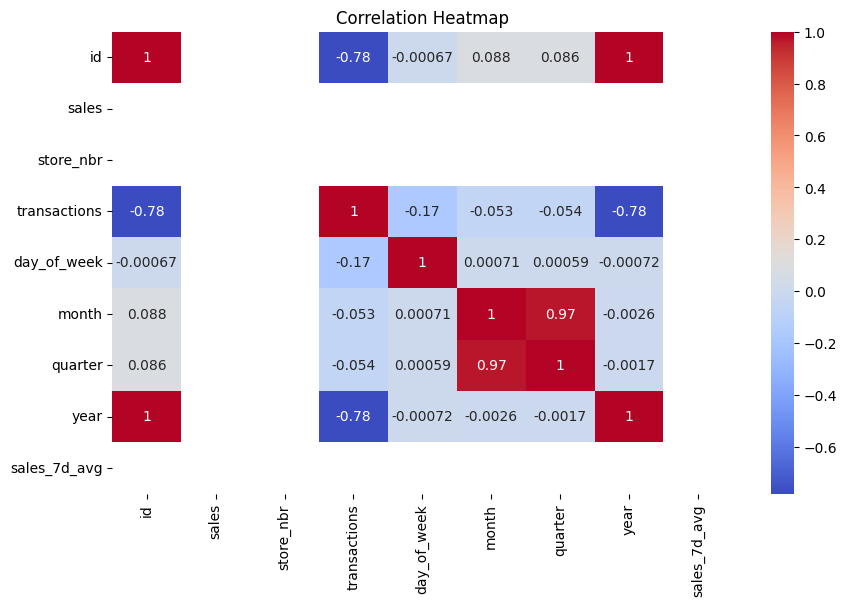

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(numeric_data.corr(),annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Feature selection

In [43]:
train = train.drop(columns=['id','quarter']) 
train.columns

Index(['sales', 'description', 'transferred', 'store_nbr', 'transactions',
       'day_of_week', 'month', 'year', 'is_weekend', 'sales_7d_avg',
       'type_Bridge', 'type_Event', 'type_Holiday', 'type_No Holiday',
       'type_Transfer', 'type_Work Day', 'locale_National', 'locale_Regional',
       'locale_name_Cayambe', 'locale_name_Cotopaxi', 'locale_name_Cuenca',
       'locale_name_Ecuador', 'locale_name_El Carmen',
       'locale_name_Esmeraldas', 'locale_name_Guaranda',
       'locale_name_Guayaquil', 'locale_name_Ibarra', 'locale_name_Imbabura',
       'locale_name_Latacunga', 'locale_name_Libertad', 'locale_name_Loja',
       'locale_name_Machala', 'locale_name_Manta', 'locale_name_Puyo',
       'locale_name_Quevedo', 'locale_name_Quito', 'locale_name_Riobamba',
       'locale_name_Salinas', 'locale_name_Santa Elena',
       'locale_name_Santo Domingo',
       'locale_name_Santo Domingo de los Tsachilas'],
      dtype='object')